In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
plt.style.use("~/.dracula.mplstyle")
import seaborn as sns

In [2]:
xlsx = pd.ExcelFile("proshares.xlsx")
print(xlsx.sheet_names)
hf = xlsx.parse(xlsx.sheet_names[1])
hf.set_index("date", inplace=True)

mer = xlsx.parse(xlsx.sheet_names[2])
mer.set_index("date", inplace=True)

hf.head()

['descriptions', 'hedge_fund_series', 'merrill_factors', 'other_data']


,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
date,,,,,
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027035,-0.006491
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032466,-0.022142
2011-10-31,0.026858,0.043593,0.043320,0.050532,0.025241
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028608,-0.007965
2011-12-31,-0.004479,0.001938,0.001796,0.012875,0.001854


# 1. For the series in the “hedge fund series” tab, report the following summary statistics:

(a) mean

(b) volatility

(c) Sharpe ratio

Annualize these statistics.

In [3]:
def portstats(v, nper=1):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    v: list-like portfolio returns
    nper: int for annualization
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    mu = v.mean() * nper
    sig = v.std() * np.sqrt(nper)
    vshaped = pd.DataFrame([mu, sig, mu / sig],
                           index=["mean", "std", "sharpe"], columns=c)
    return vshaped

stats = portstats(hf, 12)
stats

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
mean,0.050784,0.038821,0.037330,0.028100,0.025491
std,0.061507,0.053848,0.053682,0.056380,0.045484
sharpe,0.825665,0.720933,0.695382,0.498407,0.560434


# 2. For the series in the “hedge fund series” tab, calculate the following statistics related to tail-risk.

(a) Skewness

(b) Excess Kurtosis (in excess of 3)

(c) VaR (.05) - the fifth quantile of historic returns

(d) CVaR (.05) - the mean of the returns at or below the fifth quantile

(e) Maximum drawdown - include the dates of the max/min/recovery within the max drawdown
period.

There is no need to annualize any of these statistics.

In [4]:
def tailrisk(v, prob, excess=True):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    v: list-like portfolio returns
    prob: float percentile for VaR
    excess: bool whether kurtosis of normal = 0 (True) or = 3 (False)
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    sk = v.skew()
    ku = v.kurtosis() - 3 * excess
    var = v.quantile(prob)
    
    cvar = []
    mask =  hf < hf.quantile(prob)
    for name, col in mask.iteritems():
        below = v[name].loc[col]
        cvar.append(sum(below)/len(below))
    
    cvar = pd.Series(cvar, index=c)
    
    ret = pd.DataFrame([sk, ku, var, cvar],
                       index=["skew", "kurtosis", f"var_{prob}", f"cvar_{prob}"],
                       columns=c)
    return ret

tailrisk(hf, 0.05)

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
skew,-1.109248,-0.186692,-0.171632,-0.179641,-0.545085
kurtosis,3.730109,-0.570516,-0.624403,-0.418346,-0.330447
var_0.05,-0.025311,-0.025527,-0.025629,-0.028529,-0.016172
cvar_0.05,-0.038757,-0.032779,-0.032724,-0.034782,-0.026348


# 3. For the series in the “hedge fund series” tab, run a regression of each against SPY (found in the “merrill factors” tab.) Include an intercept. Report the following regression-based statistics:

(a) Market Beta

(b) Treynor Ratio

(c) Information ratio

Annualize these three statistics as appropriate.

In [24]:
def portstats(v, bm, nper=1):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    v: list-like portfolio returns
    bm: list-like benchmark
    nper: int for annualization
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    mu = v.mean() * nper
    sig = v.std() * np.sqrt(nper)
    
    beta, tr, ir = [], [], []
    for name, col in v.iteritems():
        res = sm.OLS(col, sm.add_constant(bm.values)).fit()
        
        beta.append(res.params[1])
        tr.append(mu[name] / res.params[1])
        ir.append(res.params[0] / res.resid.std() / np.sqrt(nper))
    
    beta = pd.Series(beta, index=c)
    tr = pd.Series(tr, index=c)
    ir = pd.Series(ir, index=c)
    
    ret = pd.DataFrame([mu, sig, mu / sig, beta, tr, ir],
                       index=["mean", "std", "sharpe", "beta", "treynor", "info ratio"],
                       columns=c)
    return ret

portstats(hf, bm=mer["SPY US Equity"], nper=12)

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
mean,0.050784,0.038821,0.037330,0.028100,0.025491
std,0.061507,0.053848,0.053682,0.056380,0.045484
sharpe,0.825665,0.720933,0.695382,0.498407,0.560434
beta,0.394320,0.359382,0.358034,0.369199,0.284993
treynor,0.128789,0.108021,0.104263,0.076111,0.089443
info ratio,-0.020169,-0.051272,-0.055939,-0.084218,-0.057274


# 4. Relative Performance

Discuss the previous statistics, and what they tell us about...

(a) the differences between SPY and the hedge-fund series?

(b) which performs better between HDG and QAI.

(c) whether HDG and the ML series capture the most notable properties of HFRI.

# 5. Report the correlation matrix for these assets.

(a) Show the correlations as a heat map.

(b) Which series have the highest and lowest correlations?

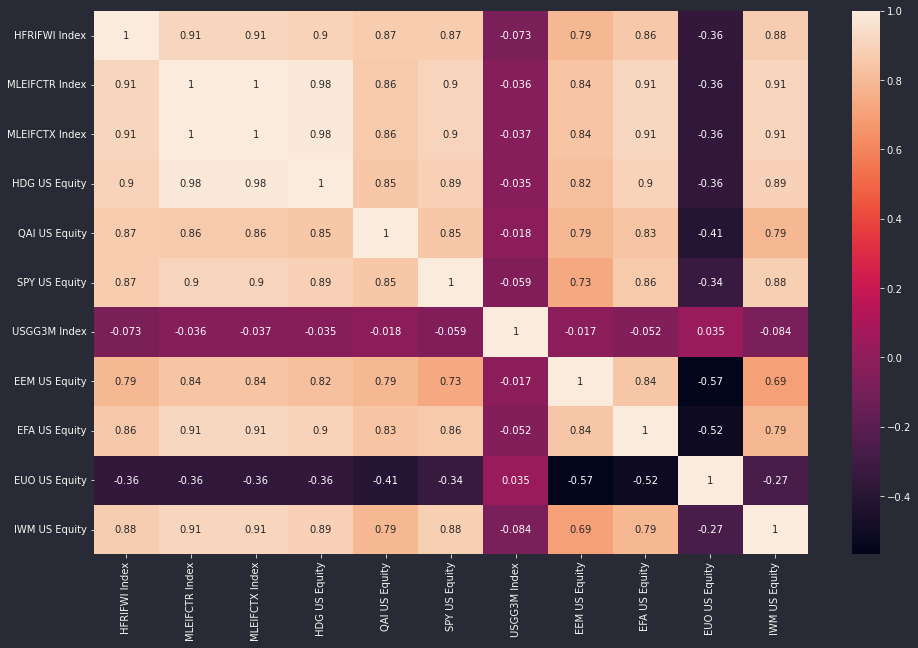

In [14]:
merged = pd.concat([hf, mer], axis=1)
mcor = merged.corr()

mcor_ranked = mcor.unstack().sort_values(ascending=False)[mcor.shape[0]:]

sns.heatmap(mcor, annot=True)
plt.show()

# 6. Replicate HFRI with the six factors listed on the “merrill factors” tab. Include a constant, and run the unrestricted regression,

$$\begin{aligned}
r_t^{hfri} &= \alpha^{merr} + x^{merr}_t \beta^{merr} + \epsilon^{merr}_t \\
\hat{r}_t^{hfri} &= \hat{\alpha}^{merr} + x^{merr}_t \hat{\beta}^{merr}
\end{aligned}$$

Note that the second equation is just our notation for the fitted replication.

(a) Report the intercept and betas.

(b) Are the betas realistic position sizes, or do they require huge long-short positions?

(c) Report the R-squared.

(d) Report the volatility of merr, (the tracking error.)

# 7. Let’s examine the replication out-of-sample.

Starting with t = 61 month of the sample, do the following:

• Use the previous 60 months of data to estimate the regression equation, (1). This gives
time-t estimates of the regression parameters, $\tilde{\alpha}^{merr}$ and $\tilde{\beta}^{merr}$

• Use the estimated regression parameters, along with the time-t regressor values, xmerr
t , to calculate the time-t replication value4 that is, with respect to the regression estimate, built “out-of-sample” (OOS).

$$\begin{aligned}
\tilde{r}_t^{hfri} &= \tilde{\alpha}^{merr} + x^{merr}_t \tilde{\beta}^{merr}
\end{aligned}$$

• Step forward to t = 62, and now use t = 2 through t = 61 for the estimation. Re-run the
steps above, and continue this process throughout the data series. Thus, we are running a
rolling, 60-month regression for each point-in-time.

How well does the out-of-sample replication perform with respect to the target?

# 8. We estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.

$$\begin{aligned}
r_t^{hfri} &= \alpha^{merr} + x^{merr}_t \beta^{merr} + \epsilon^{merr}_t \\
\check{r}_t^{hfri} &= \check{\alpha}^{merr} + x^{merr}_t \check{\beta}^{merr}
\end{aligned}$$

Report

(a) the regression beta. How does it compare to the estimated beta with an intercept, $\check{\beta}^{hfri}$?

(b) the mean of the fitted value, $\check{r}_t^{hfri}$. How does it compare to the mean of the HFRI?

(c) the correlations of the fitted values, $\check{r}_t^{hfri}$ to the HFRI. How does the correlation compare to that of the fitted values with an intercept, $\check{r}_t^{hfri}$

Do you think Merrill and ProShares fit their replicators with an intercept or not?